# "Time Series Forecasting with Statistical Models"
> "statsforecast makes forecasting with statistical models fast & easy"

- toc: true
- branch: main
- badges: true
- comments: true
- categories: [statistics, forecasting, models]
- image: images/nixtla_logo.png

## TL;DR

In this post we introduce **statsforecast**, an open-source framework tha makes the implementation of statistical models in forecasting tasks fast and easy. *statsforecast* is able to handle thousands of time series and is efficient both time and memory wise. With this library you can easily create benchmarks on which to build more complex models; it can also allows you to run your own models in a parallel fashion. In this post we also offer a guide on how to use "Forecast Value Added" for Bencharmikg different modesl and assegins competing models.

## Introduction

In this post, we will talk about using statistical models in forecasting tasks. In particular, we introduce **statsforecast**. This Python library allows fitting statistical models in a simple and computationallthousandsy efficient way for hundreds ofthousands of time series so that you can benchmark your own models quickly. Throughout this post, we will show how to use the library to calculate the Forecast Value Added of some models with respect to a benchmark model. This methodology allows us to select the best model among a variety.

## Motivation

Deep learning and Machine Learning models have demonstrated state-of-the-art performance in time series forecasting tasks. However, it is helpful to have a battery of simpler models to benchmark and validate the value that those models add.

In business problems, metrics such as Forecast Value Added (FVA) are usually used to compare the value-added of more complex models against more straightforward techniques to implement and explain to decision-makers. FVA is calculated by subtracting the loss of a benchmark model from the loss of a more complex one. In the [following example](https://www.sas.com/content/dam/SAS/en_us/doc/whitepaper1/forecast-value-added-analysis-106186.pdf), three models were fitted: Naive, Statistical, and Override. The first column shows the Mean Average Percentage Error (MAPE) of these three models. The `FVA vs. Naive` column displays in the second row the difference between the Naive's MAPE and the Statistical's MAPE, which is positive; that means that the Statistical adds value to the process. Likewise, the third row shows the difference between the Naive's MAPE and the Override's MAPE; the result is negative, so the model Override doesn't add any value.

![FVA table](fva-table.png)

A wide range of statistical base models is included in *statsforecast* that can be used for decision making or as benchmarks for implementing more complete models. Also included are models for specific tasks, such as forecasting sparse (or intermittent) time-series, i.e., time series with a high percentage of zero values, such as sales. These models exist in implementations for the R programming language but not for Python.

## statsforecast

To make benchmarking easier, we created [statsforecast](https://github.com/Nixtla/statsforecast), which is a framework to help you forecast time series using statistical models. You just need to give it a model you want to use and let *statsforecast* do the rest.

### Included models

- **ADIDA**: Temporal aggregation is used for reducing the presence of zero observations, thus mitigating the undesirable effect of the variance observed in the intervals. ADIDA uses equally sized time buckets to perform non-overlapping temporal aggregation and predict the demand over a pre-specified lead-time. The time bucket is set equal to the mean inter-demand interval. SES is used to obtain the forecasts. 
- **Croston Classic**: The method proposed by Croston to forecast series that display intermittent demand. The method decomposes the original series into the non-zero demand size and the inter-demand intervals and models them using Simple Exponential Smoothing with a predefined parameter. 
- **Croston SBA**: SBA stands for Syntetos-Boylan Approximation. A variant of the Croston's method that utilizes a debiasing factor.
- **Croston Optimized**: Like Croston, but this model optimizes the Simple Exponential Smoothing for both the non-zero demand size and the inter-demand intervals.
- **Historic average**: Simple average of the time series.
- **iMAPA**: iMAPA stands for Intermittent Multiple Aggregation Prediction Algorithm. Another way for implementing temporal aggregation in demand forecasting. However, in contrast to ADIDA that considers a single aggregation level, iMAPA considers multiple ones, aiming at capturing different dynamics of the data. Thus, iMAPA proceeds by averaging the derived point forecasts, generated using SES. 
- **Naive**: Uses the last value of the time series as forecast. The simplest model for time series forecasting.
- **Random Walk with Drift**: Projects the historic trend from the last observed value.
- **Seasonal Exponential Smoothing**: Adjusts a Simple Exponential Smoothing model for each seasonal period.
- **Seasonal Naive**: Like Naive, but this time the forecasts of the model are equal to the last known observation of the same period in order for it to capture possible weekly seasonal variations.
- **Seasonal Window Average**: Uses the last window (defined by the user) to calculate an average for each seasonal period.
- **SES**: SES stands for Simple Exponential Smoothing. This model recursively weights the most recent observations in the time series. Useful for time series with no trend.
- **TSB**: TSB stands for Teunter-Syntetos-Babai. A modification to Croston's method that replaces the inter-demand intervals component with the demand probability.
- **Window Average**: Uses the last window (defined by the user) to calculate an average.

### Usage

To create an ample set of benchmarks you can install **statsforecast** which is available in [PyPI](https://pypi.org/project/statsforecast/) (`pip install statsforecast`).

### Libraries

In [1]:
#%gist gistname: libraries-statsforecast.py
import random
from itertools import product
from IPython.display import display, Markdown
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nixtlats.data.datasets.m5 import M5, M5Evaluation

from statsforecast import StatsForecast
from statsforecast.models import (
    adida, 
    croston_classic, 
    croston_sba, 
    croston_optimized,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift, 
    seasonal_exponential_smoothing,
    seasonal_naive, 
    seasonal_window_average,
    ses, 
    tsb,
    window_average
)

### Data

In this example we use the M5 time series competition data. The objective of the competition was to validate models for intermittent demand (sales) data. To download the data we used [nixtlats](https://github.com/Nixtla/nixtlats).

In [2]:
#%gist gistname: get-data-statsforecast.py
series, _, S_df = M5.load('data')
horizon = 28

The function `M5.load` returns train + test data, so we need to separate them.

In [3]:
#%gist gistname: split-data-statsforecast.py
series_test = series.groupby('unique_id').tail(horizon).copy()
series = series.drop(series_test.index)

In [4]:
#%gist gistname: data-statsforecast.py upload: both
series['unique_id'] = series['unique_id'].astype('object')
series = series.set_index('unique_id')
series.reset_index()

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0
...,...,...,...
46796215,HOUSEHOLD_2_516_WI_3,2016-05-18,0.0
46796216,HOUSEHOLD_2_516_WI_3,2016-05-19,0.0
46796217,HOUSEHOLD_2_516_WI_3,2016-05-20,0.0
46796218,HOUSEHOLD_2_516_WI_3,2016-05-21,0.0


In [5]:
#%gist gistname: n-ts-statsforecast.py
series.index.unique().shape

(30490,)

This is the required input format.
* an index named **unique_id** that identifies each time series. In this example, we have 30,490 time series.
* a **ds** column with the dates.
* a **y** column with the values.


### Training

We now define the statistical models we will use. We must define a list of functions. If the model has additional parameters, besides the forecast horizon, it must be included as a tuple with the model and the additional parameters.

In [6]:
#%gist gistname: models-statsforecast.py
seasonality = 7 #daily data

models = [
    adida,
    croston_classic,
    croston_sba,
    croston_optimized,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift,
    (seasonal_exponential_smoothing, seasonality, 0.2),
    (seasonal_naive, seasonality),
    (seasonal_window_average, seasonality, 2 * seasonality),
    (ses, 0.1),
    (tsb, 0.3, 0.2),
    (window_average, 2 * seasonality)
    
]

Now we define our trainer, `StatsForecast`, where we define the models we want to use, the frequency of the data and the number of cores used to parallelize the training job.

In this way adjusting these models and generating forecasts is as simple as the following lines. The main class is `StatsForecast`; it receives four parameters:

- `df`: A pandas dataframe with time series in long format.
- `models`: A list of models to fit each time series.
- `freq`: Frequency of the time series.
- `n_jobs`: Number of cores to be used in the fitting process. The default is 1 job. To compute the process in parallel you can use the `cpu_count()` function from `multiprocessing`.

In [7]:
#%gist gistname: forecast-statsforecast.py upload: both
fcst = StatsForecast(df=series, models=models, freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for adida.
INFO:statsforecast.core:Computed forecasts for croston_classic.
INFO:statsforecast.core:Computed forecasts for croston_sba.
INFO:statsforecast.core:Computed forecasts for croston_optimized.
INFO:statsforecast.core:Computed forecasts for historic_average.
INFO:statsforecast.core:Computed forecasts for imapa.
INFO:statsforecast.core:Computed forecasts for naive.
INFO:statsforecast.core:Computed forecasts for random_walk_with_drift.
INFO:statsforecast.core:Computed forecasts for seasonal_exponential_smoothing_season_length-7_alpha-0.2.
INFO:statsforecast.core:Computed forecasts for seasonal_naive_season_length-7.
INFO:statsforecast.core:Computed forecasts for seasonal_window_average_season_length-7_window_size-14.
INFO:statsforecast.core:Computed forecasts for ses_alpha-0.1.
INFO:statsforecast.core:Computed forecasts for tsb_alpha_d-0.3_alpha_p-0.2.
INFO:statsforecast.core:Computed forecasts 

CPU times: user 5.33 s, sys: 1.58 s, total: 6.91 s
Wall time: 2min 29s


,unique_id,ds,adida,croston_classic,croston_sba,croston_optimized,historic_average,imapa,naive,random_walk_with_drift,seasonal_exponential_smoothing_season_length-7_alpha-0.2,seasonal_naive_season_length-7,seasonal_window_average_season_length-7_window_size-14,ses_alpha-0.1,tsb_alpha_d-0.3_alpha_p-0.2,window_average_window_size-14
0,FOODS_1_001_CA_1,2016-05-23,0.791852,0.898247,0.853334,0.898247,0.786193,0.705835,0.0,-0.001546,0.981245,0.0,1.357143,0.619817,0.402382,0.642857
1,FOODS_1_001_CA_1,2016-05-24,0.791852,0.898247,0.853334,0.898247,0.786193,0.705835,0.0,-0.003093,0.483033,0.0,1.000000,0.619817,0.402382,0.642857
2,FOODS_1_001_CA_1,2016-05-25,0.791852,0.898247,0.853334,0.898247,0.786193,0.705835,0.0,-0.004639,1.090706,0.0,0.785714,0.619817,0.402382,0.642857
3,FOODS_1_001_CA_1,2016-05-26,0.791852,0.898247,0.853334,0.898247,0.786193,0.705835,0.0,-0.006186,1.375969,1.0,0.357143,0.619817,0.402382,0.642857
4,FOODS_1_001_CA_1,2016-05-27,0.791852,0.898247,0.853334,0.898247,0.786193,0.705835,0.0,-0.007732,0.592922,0.0,1.071429,0.619817,0.402382,0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,HOUSEHOLD_2_516_WI_3,2016-06-15,0.055719,0.076422,0.072601,0.076422,0.127320,0.052637,0.0,-0.012378,0.000198,0.0,0.000000,0.052041,0.034953,0.071429
853716,HOUSEHOLD_2_516_WI_3,2016-06-16,0.055719,0.076422,0.072601,0.076422,0.127320,0.052637,0.0,-0.012893,0.004130,0.0,0.071429,0.052041,0.034953,0.071429
853717,HOUSEHOLD_2_516_WI_3,2016-06-17,0.055719,0.076422,0.072601,0.076422,0.127320,0.052637,0.0,-0.013409,0.025479,0.0,0.071429,0.052041,0.034953,0.071429
853718,HOUSEHOLD_2_516_WI_3,2016-06-18,0.055719,0.076422,0.072601,0.076422,0.127320,0.052637,0.0,-0.013925,0.110304,0.0,0.071429,0.052041,0.034953,0.071429


### Forecast Value Added

In this example, we'll use the `naive` model as a benchmark; this is the simpler model among the fitted ones (it only takes the last value of the time series as forecast).

In [8]:
#%gist gistname: test-set-statsforecast.py
forecasts = forecasts.reset_index().merge(series_test, how='left', on=['unique_id', 'ds'])
models = forecasts.drop(columns=['unique_id', 'ds', 'y']).columns.to_list()

In [9]:
#%gist gistname: fva-statsforecast.py upload: both
from nixtlats.losses.numpy import mape

y = forecasts['y'].values
mape_naive = mape(y, forecasts['naive'].values)

fva = {}
for model in models:
    mape_model = mape(y, forecasts[model].values)
    fva[model] = mape_naive - mape_model
    
pd.DataFrame(fva, index=['FVA']).T.sort_values('FVA').rename_axis('model').reset_index()

/home/federicogarza2/anaconda3/envs/statsforecast/lib/python3.9/site-packages/nixtlats/losses/numpy.py:17: RuntimeWarning: divide by zero encountered in true_divide
  div = a / b
/home/federicogarza2/anaconda3/envs/statsforecast/lib/python3.9/site-packages/nixtlats/losses/numpy.py:17: RuntimeWarning: invalid value encountered in true_divide
  div = a / b


,model,FVA
0,random_walk_with_drift,-0.448301
1,naive,0.000000
2,seasonal_naive_season_length-7,3.424680
3,seasonal_exponential_smoothing_season_length-7...,12.446222
4,tsb_alpha_d-0.3_alpha_p-0.2,12.879661
5,seasonal_window_average_season_length-7_window...,13.451803
6,historic_average,13.770679
7,window_average_window_size-14,13.779336
8,imapa,14.131600
9,adida,14.187038


As the table shows, the Forecast Value Added against the naive model is positive for the majority of the models, except for the `random_walk_with_drift` model. And also, the table shows that `croston_sba` is the model adding the most value.

### Visualization

In this section we present visual examples of the forecasts generated.

In [10]:
#%gist gistname: grid-viz-statsforecast.py
def plot_grid_prediction(y, y_hat, models, plot_random=True, unique_ids=None):
    """
    y: pandas df
        panel with columns unique_id, ds, y
    y_hat: pandas df
        panel with columns unique_id, ds, y_hat
    models: List[str]
        List of models to plot
    plot_random: bool
        if unique_ids will be sampled
    unique_ids: list
        unique_ids to plot
    """
    pd.plotting.register_matplotlib_converters()

    fig, axes = plt.subplots(4, 1, figsize = (16, 24))

    if not unique_ids:
        unique_ids = y['unique_id'].unique()

    assert len(unique_ids) >= 4, "Must provide at least 4 ts"

    if plot_random:
        unique_ids = random.choices(unique_ids, k=4)

    for i, (idx, idy) in enumerate(product(range(4), range(1))):
        y_uid = y[y.unique_id == unique_ids[i]]
        y_uid_hat = y_hat[y_hat.unique_id == unique_ids[i]]

        axes[idx].plot(y_uid.ds, y_uid.y, label = 'y', marker='.')
        for model in models:
            axes[idx].plot(y_uid_hat.ds, y_uid_hat[model], label=model, marker='.')
        axes[idx].set_title(unique_ids[i])
        axes[idx].legend(loc='upper left')

    plt.show()

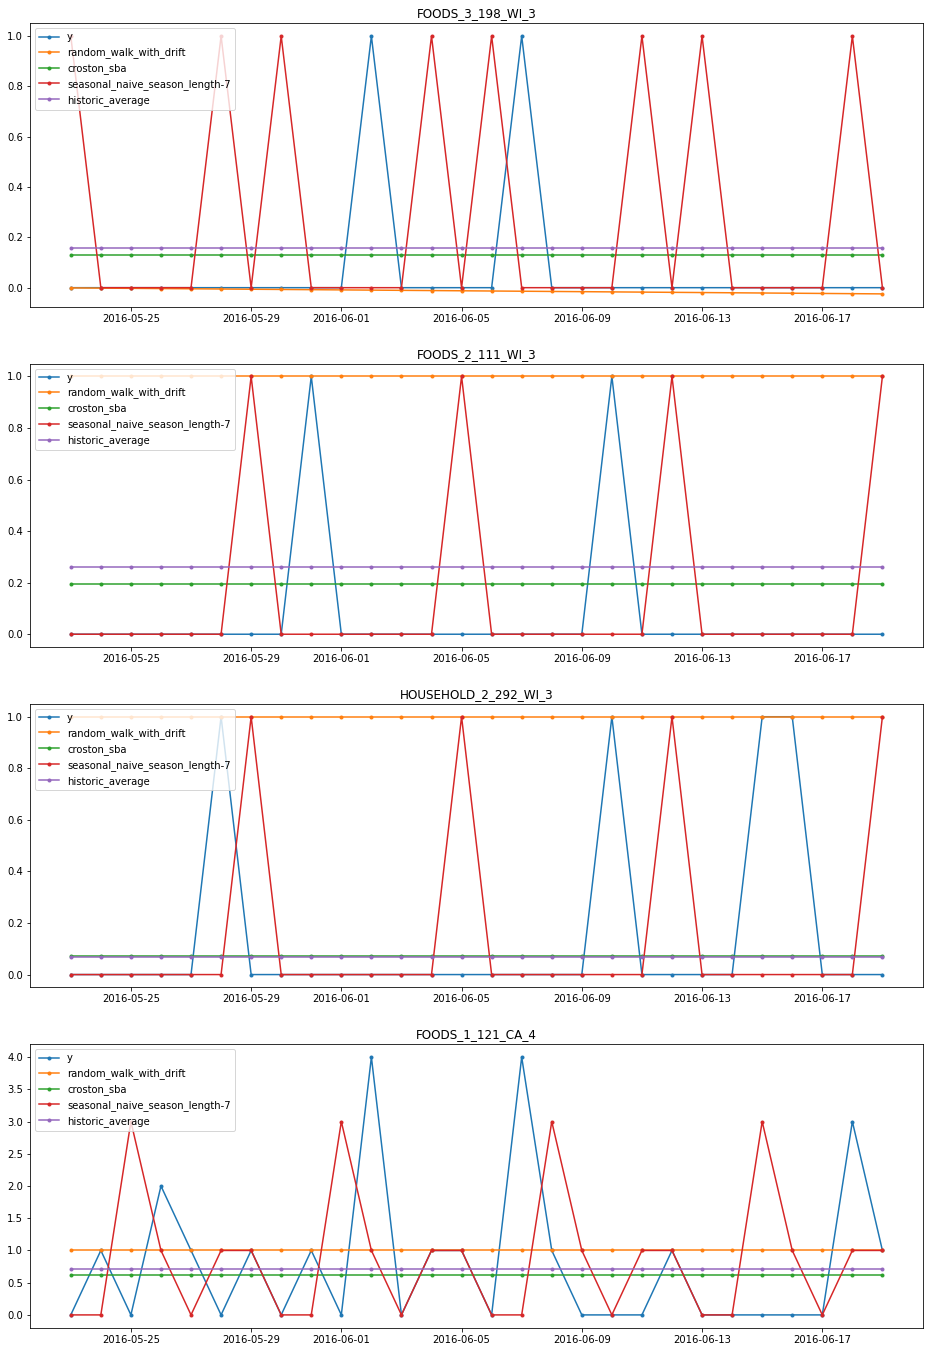

In [11]:
#%gist gistname: plot-forecasts-statsforecast.py
plot_models = random.sample(models, k=4)
plot_grid_prediction(forecasts[['unique_id', 'ds', 'y']], forecasts[['unique_id', 'ds'] + models], models=plot_models)

## Evaluation

We now evaluate the performance of the solution. We use the mean of the forecasts as the final forecast.
With this library you can easily create benchmarks on which to build more complex models.

In [12]:
#%gist gistname: evaluation-statsforecast.py upload: both
forecasts['y_hat'] = forecasts.drop(columns=['unique_id', 'ds', 'y']).mean(axis=1)

y_hat = forecasts.set_index(['unique_id', 'ds'])[['y_hat']].unstack()
y_hat = y_hat.droplevel(0, 1).reset_index()

y_hat = y_hat.merge(S_df, how='left', on=['unique_id'])

M5Evaluation.evaluate('data', y_hat).reset_index()

,index,wrmsse
0,Total,0.905419
1,Level1,0.817116
2,Level2,0.851138
3,Level3,0.870212
4,Level4,0.829796
5,Level5,0.888274
6,Level6,0.882609
7,Level7,0.929434
8,Level8,0.892828
9,Level9,0.938251


Thus, we obtain the following table,

In [13]:
#%gist gistname: benchmarks-statsforecast.py upload: both
pd.DataFrame(
    {'model': ['statsforecast', 'MLP', 'RF', 'Naive'],
     'WRMSSE': [0.905, 0.977, 1.010, 1.752]}
)

,model,WRMSSE
0,statsforecast,0.905
1,MLP,0.977
2,RF,1.010
3,Naive,1.752


For a description of the additional results, see [this medium post](https://aws.plainenglish.io/automated-time-series-forecasting-pipeline-662e0feadd98). In conclusion, with statsforecast we obtained good benchmarks quickly.

## Create your own model

Aditionally you can use the full power of `StatsForecast` to parallelize your own model. You just need to define a function with mandatory parameters `y`, the target time series, and `h`, the horizon to forecast; in addition you can add more optional parameters. The function's output must be a numpy array of size `h`. In the following example we'll fit a linear regression against time; this is a very basic model but it is useful to explain how to get the full potential of `statsforecast`.

In [14]:
#%gist gistname: lr-statsforecast.py
from sklearn.linear_model import LinearRegression

def linear_regression_time(y: np.ndarray, h: int) -> np.ndarray:
    X = np.arange(y.shape[0] + h).reshape(-1, 1) + 1
    X_train = X[:y.shape[0]]
    X_test = X[-h:]
    
    reg = LinearRegression().fit(X_train, y)
    
    return reg.predict(X_test)

In [15]:
#%gist gistname: lr-results-statsforecast.py upload: both
fcst = StatsForecast(df=series, models=[linear_regression_time], freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for linear_regression_time.


CPU times: user 4.21 s, sys: 866 ms, total: 5.07 s
Wall time: 11.1 s


,unique_id,ds,linear_regression_time
0,FOODS_1_001_CA_1,2016-05-23,0.593921
1,FOODS_1_001_CA_1,2016-05-24,0.593723
2,FOODS_1_001_CA_1,2016-05-25,0.593525
3,FOODS_1_001_CA_1,2016-05-26,0.593327
4,FOODS_1_001_CA_1,2016-05-27,0.593129
...,...,...,...
853715,HOUSEHOLD_2_516_WI_3,2016-06-15,0.093338
853716,HOUSEHOLD_2_516_WI_3,2016-06-16,0.093304
853717,HOUSEHOLD_2_516_WI_3,2016-06-17,0.093269
853718,HOUSEHOLD_2_516_WI_3,2016-06-18,0.093235


A more complicated example with extra parameters would be a Lasso regression as follows,

In [16]:
#%gist gistname: lasso-statsforecast.py
from sklearn.linear_model import Lasso

def lasso_regression_time(y: np.ndarray, h: int, alpha: float) -> np.ndarray:
    X = np.arange(y.shape[0] + h).reshape(-1, 1) + 1
    X_train = X[:y.shape[0]]
    X_test = X[-h:]
    
    reg = Lasso(alpha=alpha).fit(X_train, y)
    
    return reg.predict(X_test)

Instead of passing the model, you just need to pass a tuple with the function and the parameter you want to use,

In [17]:
#%gist gistname: lasso-results-statsforecast.py upload: both
fcst = StatsForecast(df=series, models=[(lasso_regression_time, 10)], freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for lasso_regression_time_alpha-10.


CPU times: user 4.16 s, sys: 917 ms, total: 5.08 s
Wall time: 12.7 s


,unique_id,ds,lasso_regression_time_alpha-10
0,FOODS_1_001_CA_1,2016-05-23,0.624848
1,FOODS_1_001_CA_1,2016-05-24,0.624682
2,FOODS_1_001_CA_1,2016-05-25,0.624516
3,FOODS_1_001_CA_1,2016-05-26,0.624350
4,FOODS_1_001_CA_1,2016-05-27,0.624184
...,...,...,...
853715,HOUSEHOLD_2_516_WI_3,2016-06-15,0.125015
853716,HOUSEHOLD_2_516_WI_3,2016-06-16,0.125013
853717,HOUSEHOLD_2_516_WI_3,2016-06-17,0.125010
853718,HOUSEHOLD_2_516_WI_3,2016-06-18,0.125008


Finally, you can train both models and a naive model (for benchmarking purposes) at the same time defining the models list as follows,

In [18]:
#%gist gistname: lr-lasso-statsforecast.py upload: both
models = [naive, linear_regression_time, (lasso_regression_time, 10)]

fcst = StatsForecast(df=series, models=models, freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for naive.
INFO:statsforecast.core:Computed forecasts for linear_regression_time.
INFO:statsforecast.core:Computed forecasts for lasso_regression_time_alpha-10.


CPU times: user 4.26 s, sys: 990 ms, total: 5.25 s
Wall time: 20.3 s


,unique_id,ds,naive,linear_regression_time,lasso_regression_time_alpha-10
0,FOODS_1_001_CA_1,2016-05-23,0.0,0.593921,0.624848
1,FOODS_1_001_CA_1,2016-05-24,0.0,0.593723,0.624682
2,FOODS_1_001_CA_1,2016-05-25,0.0,0.593525,0.624516
3,FOODS_1_001_CA_1,2016-05-26,0.0,0.593327,0.624350
4,FOODS_1_001_CA_1,2016-05-27,0.0,0.593129,0.624184
...,...,...,...,...,...
853715,HOUSEHOLD_2_516_WI_3,2016-06-15,0.0,0.093338,0.125015
853716,HOUSEHOLD_2_516_WI_3,2016-06-16,0.0,0.093304,0.125013
853717,HOUSEHOLD_2_516_WI_3,2016-06-17,0.0,0.093269,0.125010
853718,HOUSEHOLD_2_516_WI_3,2016-06-18,0.0,0.093235,0.125008


Now we can calculate the FVA for the linear and ridge regression based on the naive model.

In [19]:
#%gist gistname: own-models-test-set-statsforecast.py
forecasts = forecasts.reset_index().merge(series_test, how='left', on=['unique_id', 'ds'])
models = forecasts.drop(columns=['unique_id', 'ds', 'y']).columns.to_list()

In [20]:
#%gist gistname: own-models-fva-statsforecast.py upload: both
y = forecasts['y'].values
mape_naive = mape(y, forecasts['naive'].values)

fva = {}
for model in models:
    mape_model = mape(y, forecasts[model].values)
    fva[model] = mape_naive - mape_model
    
pd.DataFrame(fva, index=['FVA']).T.sort_values('FVA').rename_axis('model').reset_index()

/home/federicogarza2/anaconda3/envs/statsforecast/lib/python3.9/site-packages/nixtlats/losses/numpy.py:17: RuntimeWarning: divide by zero encountered in true_divide
  div = a / b
/home/federicogarza2/anaconda3/envs/statsforecast/lib/python3.9/site-packages/nixtlats/losses/numpy.py:17: RuntimeWarning: invalid value encountered in true_divide
  div = a / b


,model,FVA
0,naive,0.000000
1,linear_regression_time,12.842381
2,lasso_regression_time_alpha-10,13.062057


So, the table shows a positive FVA for both models; we can also see that the regularization provided by the Ridge regression improves the FVA.

## WIP

**statsforecast** is a work in progress. In next releases we plan to include:
- Automated backtesting.
- Ensembles (such as [fforma](https://github.com/FedericoGarza/fforma)).
- More statistical models with exogenous variables.

## Next steps

If you're interested you can learn more in the following resources:
* GitHub repo: https://github.com/Nixtla/statsforecast
* Documentation: https://nixtla.github.io/statsforecast/